## Data file cleanup and merge

In [215]:
import pandas as pd
import numpy as np
from scipy import stats

Read in files

In [169]:
sail_data = pd.read_csv('detmacraceresults.csv', names=['Division_course', 'Year', 'Sail_No',\
                                                    'Boat_name', 'Finish_time', 'Elapsed_Time', 'Corrected_Time', 'Boat_class', 'Division_placing'])
sail_data_2019 = pd.read_csv('detmacraceresults_2019.csv', names=['Division_course', 'Year', 'Sail_No',\
                                                         'Boat_name', 'Finish_time', 'Elapsed_Time', 'Corrected_Time', 'Boat_class', 'Division_placing'])

Duplicate elapsed time and corrected time columns without DNS, DNF, Retired for analysis

In [170]:
sail_data['cln_elps_tm'] = sail_data['Elapsed_Time'].replace(['DNS', 'DNF', 'Retired'],np.nan)
sail_data['cln_crrct_tm'] = sail_data['Corrected_Time'].replace(['DNS', 'DNF', 'Retired'],np.nan)
sail_data_2019['cln_elps_tm'] = sail_data_2019['Elapsed_Time'].replace(['DNS', 'DNF', 'Retired'],np.nan)
sail_data_2019['cln_crrct_tm'] = sail_data_2019['Corrected_Time'].replace(['DNS', 'DNF', 'Retired'],np.nan)

Define function to convert time strings to seconds for analysis

In [171]:
def pdtime_cnvrt(dtafrm, timecolname):
    # new data frame with split value columns 
    new = dtafrm[timecolname].str.split(":", expand = True)
    # columns to overwrite and hold hh,mm,ss strngs
    dtafrm['hh'] = new[0]
    dtafrm['mm'] = new[1]
    dtafrm['ss'] = new[2]
    # create new time column in sec
    outptcolnam = timecolname +'_sec'
    dtafrm[outptcolnam] = pd.to_numeric(dtafrm['hh'], errors='coerce')*3600 +\
        pd.to_numeric(dtafrm['mm'], errors='coerce')*60 +\
        pd.to_numeric(dtafrm['ss'], errors='coerce')
    return dtafrm[outptcolnam]

use pdtime_cnvrt fxn to calculate correction time in seconds

In [172]:
sail_data['crctn_in_sec'] = pdtime_cnvrt(sail_data, 'cln_elps_tm') - \
    pdtime_cnvrt(sail_data, 'cln_crrct_tm')
sail_data_2019['crctn_in_sec'] = pdtime_cnvrt(sail_data_2019, 'cln_elps_tm') - \
    pdtime_cnvrt(sail_data_2019, 'cln_crrct_tm')

In [173]:
#count the number of DNFs per year; these should be retained still
list(sail_data[sail_data['Elapsed_Time'] == 'DNF'].groupby('Year'))

[(2002,
                      Division_course  Year    Sail_No  Boat_name Finish_time  \
  3559  Division I - PHRF Southampton  2002  USA 50996  Promotion         DNF   
  3663        Division V - Open Class  2002        T 1      Ollie         DNF   
  
       Elapsed_Time Corrected_Time      Boat_class Division_placing cln_elps_tm  \
  3559          DNF            DNF  PHRF A / GL 50              138         NaN   
  3663          DNF            DNF            Open                8         NaN   
  
       cln_crrct_tm   hh   mm   ss  cln_elps_tm_sec  cln_crrct_tm_sec  \
  3559          NaN  NaN  NaN  NaN              NaN               NaN   
  3663          NaN  NaN  NaN  NaN              NaN               NaN   
  
        crctn_in_sec  
  3559           NaN  
  3663           NaN  ),
 (2004,
                                 Division_course  Year    Sail_No  \
  3025             Division I - PHRF Southampton  2004  USA 25443   
  3026             Division I - PHRF Southampton  2004 

Create new winsorized data files without outliers

In [174]:
sail_data_winsor = sail_data.loc[abs(sail_data['crctn_in_sec']) < 200000]
sail_data_2019_winsor = sail_data_2019.loc[abs(sail_data['crctn_in_sec']) < 200000]

test that sail_data retains count of DNFs

In [175]:
list(sail_data[sail_data['Elapsed_Time'] == 'DNF'].groupby('Year'))

[(2002,
                      Division_course  Year    Sail_No  Boat_name Finish_time  \
  3559  Division I - PHRF Southampton  2002  USA 50996  Promotion         DNF   
  3663        Division V - Open Class  2002        T 1      Ollie         DNF   
  
       Elapsed_Time Corrected_Time      Boat_class Division_placing cln_elps_tm  \
  3559          DNF            DNF  PHRF A / GL 50              138         NaN   
  3663          DNF            DNF            Open                8         NaN   
  
       cln_crrct_tm   hh   mm   ss  cln_elps_tm_sec  cln_crrct_tm_sec  \
  3559          NaN  NaN  NaN  NaN              NaN               NaN   
  3663          NaN  NaN  NaN  NaN              NaN               NaN   
  
        crctn_in_sec  
  3559           NaN  
  3663           NaN  ),
 (2004,
                                 Division_course  Year    Sail_No  \
  3025             Division I - PHRF Southampton  2004  USA 25443   
  3026             Division I - PHRF Southampton  2004 

Merge original and winsorized data files

In [176]:
merge_sail_winsor = pd.concat([sail_data_2019_winsor, sail_data_winsor], axis = 0)
merge_sail = pd.concat([sail_data_2019, sail_data], axis = 0)

test to ensure merge_sail still has DNFs

In [177]:
list(merge_sail[merge_sail['Elapsed_Time'] == 'DNF'].groupby('Year'))

[(2002,
                      Division_course  Year    Sail_No  Boat_name Finish_time  \
  3559  Division I - PHRF Southampton  2002  USA 50996  Promotion         DNF   
  3663        Division V - Open Class  2002        T 1      Ollie         DNF   
  
       Elapsed_Time Corrected_Time      Boat_class Division_placing cln_elps_tm  \
  3559          DNF            DNF  PHRF A / GL 50              138         NaN   
  3663          DNF            DNF            Open                8         NaN   
  
       cln_crrct_tm   hh   mm   ss  cln_elps_tm_sec  cln_crrct_tm_sec  \
  3559          NaN  NaN  NaN  NaN              NaN               NaN   
  3663          NaN  NaN  NaN  NaN              NaN               NaN   
  
        crctn_in_sec  
  3559           NaN  
  3663           NaN  ),
 (2004,
                                 Division_course  Year    Sail_No  \
  3025             Division I - PHRF Southampton  2004  USA 25443   
  3026             Division I - PHRF Southampton  2004 

Divison and course name are merged, break out Division_only to allow analysis by division

In [178]:
merge_sail_winsor['Division_only'] = merge_sail_winsor['Division_course'].str.slice(0,12)
merge_sail['Division_only'] = merge_sail['Division_course'].str.slice(0,12)

test to ensure we still have DNFs in original merge file

In [179]:
list(merge_sail[merge_sail['Elapsed_Time'] == 'DNF'].groupby('Year'))

[(2002,
                      Division_course  Year    Sail_No  Boat_name Finish_time  \
  3559  Division I - PHRF Southampton  2002  USA 50996  Promotion         DNF   
  3663        Division V - Open Class  2002        T 1      Ollie         DNF   
  
       Elapsed_Time Corrected_Time      Boat_class Division_placing cln_elps_tm  \
  3559          DNF            DNF  PHRF A / GL 50              138         NaN   
  3663          DNF            DNF            Open                8         NaN   
  
       cln_crrct_tm   hh   mm   ss  cln_elps_tm_sec  cln_crrct_tm_sec  \
  3559          NaN  NaN  NaN  NaN              NaN               NaN   
  3663          NaN  NaN  NaN  NaN              NaN               NaN   
  
        crctn_in_sec Division_only  
  3559           NaN  Division I -  
  3663           NaN  Division V -  ),
 (2004,
                                 Division_course  Year    Sail_No  \
  3025             Division I - PHRF Southampton  2004  USA 25443   
  3026       

However, the winsorized file doesn't have the DNFs

In [187]:
list(merge_sail_winsor[merge_sail_winsor['Elapsed_Time'] == 'DNF'].groupby('Year'))

[]

In [180]:
merge_sail.head()

,Division_course,Year,Sail_No,Boat_name,Finish_time,Elapsed_Time,Corrected_Time,Boat_class,Division_placing,cln_elps_tm,cln_crrct_tm,hh,mm,ss,cln_elps_tm_sec,cln_crrct_tm_sec,crctn_in_sec,Division_only
0,Division I - Cove Island,2019,USA 25168,Stripes,Sunday - 21:49:33,32:09:33,35:47:58,Class B,1,32:09:33,35:47:58,35,47,58,115773.0,128878.0,-13105.0,Division I -
1,Division I - Cove Island,2019,USA 323,Equation,Sunday - 21:31:28,31:51:28,35:50:01,Class B,2,31:51:28,35:50:01,35,50,01,114688.0,129001.0,-14313.0,Division I -
2,Division I - Cove Island,2019,USA 70,Evolution,Sunday - 21:52:16,32:12:16,36:01:02,Class B,3,32:12:16,36:01:02,36,01,02,115936.0,129662.0,-13726.0,Division I -
3,Division I - Cove Island,2019,USA 97999,Arctos,Sunday - 21:42:41,32:02:41,37:12:14,Class A,4,32:02:41,37:12:14,37,12,14,115361.0,133934.0,-18573.0,Division I -
4,Division I - Cove Island,2019,USA 482,Talisman,Sunday - 23:30:28,33:50:28,37:22:02,Class B,5,33:50:28,37:22:02,37,22,02,121828.0,134522.0,-12694.0,Division I -


In [92]:
merge_sail['Division_only'] = merge_sail['Division_course'].str.slice(0,12)

In [93]:
merge_sail.head()

,Division_course,Year,Sail_No,Boat_name,Finish_time,Elapsed_Time,Corrected_Time,Boat_class,Division_placing,cln_elps_tm,cln_crrct_tm,hh,mm,ss,cln_elps_tm_sec,cln_crrct_tm_sec,crctn_in_sec,Division_only
0,Division I - Cove Island,2019,USA 25168,Stripes,Sunday - 21:49:33,32:09:33,35:47:58,Class B,1,32:09:33,35:47:58,35,47,58,115773.0,128878.0,-13105.0,Division I -
1,Division I - Cove Island,2019,USA 323,Equation,Sunday - 21:31:28,31:51:28,35:50:01,Class B,2,31:51:28,35:50:01,35,50,01,114688.0,129001.0,-14313.0,Division I -
2,Division I - Cove Island,2019,USA 70,Evolution,Sunday - 21:52:16,32:12:16,36:01:02,Class B,3,32:12:16,36:01:02,36,01,02,115936.0,129662.0,-13726.0,Division I -
3,Division I - Cove Island,2019,USA 97999,Arctos,Sunday - 21:42:41,32:02:41,37:12:14,Class A,4,32:02:41,37:12:14,37,12,14,115361.0,133934.0,-18573.0,Division I -
4,Division I - Cove Island,2019,USA 482,Talisman,Sunday - 23:30:28,33:50:28,37:22:02,Class B,5,33:50:28,37:22:02,37,22,02,121828.0,134522.0,-12694.0,Division I -


## Graphical analysis

In [193]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

Examine distribution of correction time

Text(0.5, 1.0, 'Handicap time for yrs 2002-2019')

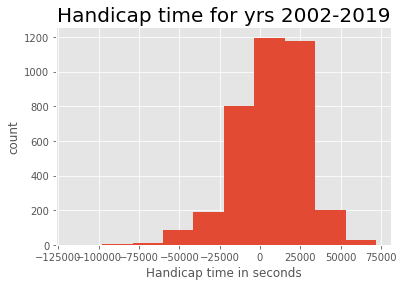

In [210]:
plt.hist(merge_sail_winsor['crctn_in_sec'])
plt.xlabel('Handicap time in seconds')
plt.ylabel('count')
plt.title('Handicap time for yrs 2002-2019', fontsize=20)

Boxplot of Correction time, no clear trend between classes

Text(0, 0.5, 'Correction in seconds')

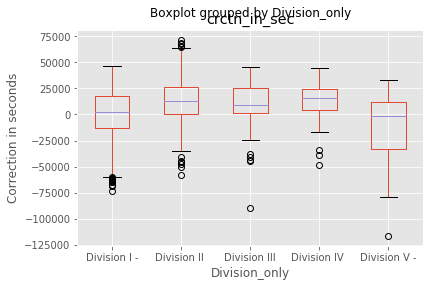

In [182]:
merge_sail_winsor.boxplot(by='Division_only', column='crctn_in_sec')
plt.ylabel('Correction in seconds')

Text(0.5, 1.0, 'Adjusted finish time vs Handicap time for yrs 2002-2019')

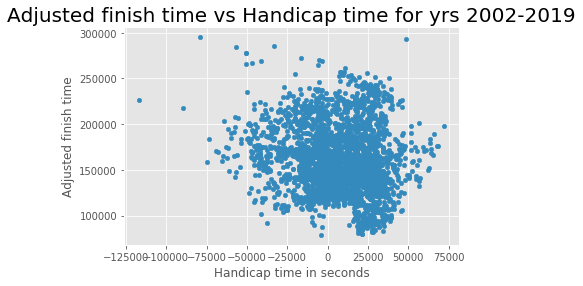

In [211]:
merge_sail_winsor.plot.scatter('crctn_in_sec', 'cln_crrct_tm_sec')
plt.xlabel('Handicap time in seconds')
plt.ylabel('Adjusted finish time')
plt.title('Adjusted finish time vs Handicap time for yrs 2002-2019', fontsize=20)

This is all boats, grouped by year.  Trends vary across years.

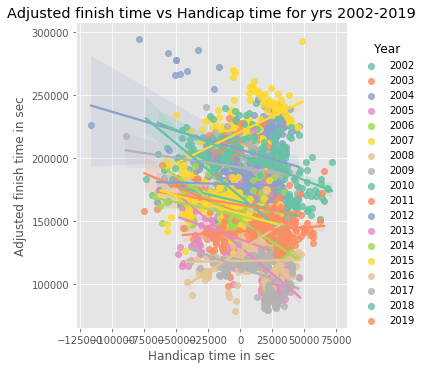

In [214]:
g = sns.lmplot("crctn_in_sec", "cln_crrct_tm_sec", merge_sail_winsor, hue="Year", palette="Set2")
g = (g.set_axis_labels("Handicap time in sec","Adjusted finish time in sec"))#.set(xlim=(0,10),ylim=(0,100)))
plt.title("Adjusted finish time vs Handicap time for yrs 2002-2019")
plt.show(g)

In [225]:
a = merge_sail_winsor[merge_sail_winsor['Year']==2016]['crctn_in_sec']
b = merge_sail_winsor[merge_sail_winsor['Year']==2007]['crctn_in_sec']
c = merge_sail_winsor[merge_sail_winsor['Year']==2010]['crctn_in_sec']

In [226]:
stats.f_oneway(a, b, c)

F_onewayResult(statistic=32.89465924556544, pvalue=2.994565140049243e-14)

These are all boats grouped by diviskon here.  Trends vary by division it seems.

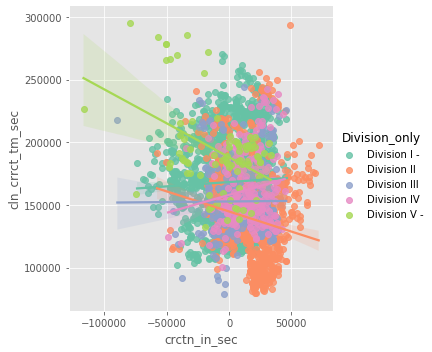

In [247]:
g = sns.lmplot("crctn_in_sec", "cln_crrct_tm_sec", merge_sail_winsor, hue="Division_only", palette="Set2")

Can see that for many years the division 1 (big boats) had a trend of increasing corrected
time with correction factor

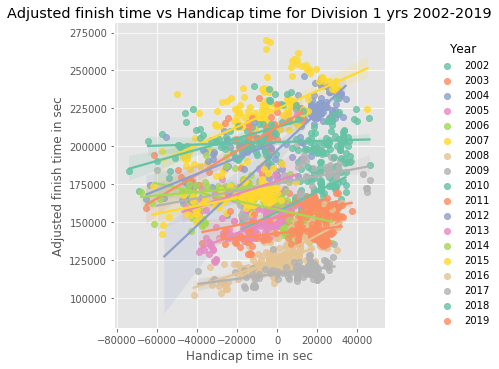

In [252]:
g = sns.lmplot("crctn_in_sec", "cln_crrct_tm_sec", merge_sail_winsor[merge_sail_winsor['Division_only']\
            =='Division I -'], hue="Year", palette="Set2")
g = (g.set_axis_labels("Handicap time in sec","Adjusted finish time in sec"))#.set(xlim=(0,10),ylim=(0,100)))
plt.title("Adjusted finish time vs Handicap time for Division 1 yrs 2002-2019")
plt.show(g)

In [189]:
merge_sail_winsor.head()

,Division_course,Year,Sail_No,Boat_name,Finish_time,Elapsed_Time,Corrected_Time,Boat_class,Division_placing,cln_elps_tm,cln_crrct_tm,hh,mm,ss,cln_elps_tm_sec,cln_crrct_tm_sec,crctn_in_sec,Division_only
0,Division I - Cove Island,2019,USA 25168,Stripes,Sunday - 21:49:33,32:09:33,35:47:58,Class B,1,32:09:33,35:47:58,35,47,58,115773.0,128878.0,-13105.0,Division I -
1,Division I - Cove Island,2019,USA 323,Equation,Sunday - 21:31:28,31:51:28,35:50:01,Class B,2,31:51:28,35:50:01,35,50,01,114688.0,129001.0,-14313.0,Division I -
2,Division I - Cove Island,2019,USA 70,Evolution,Sunday - 21:52:16,32:12:16,36:01:02,Class B,3,32:12:16,36:01:02,36,01,02,115936.0,129662.0,-13726.0,Division I -
3,Division I - Cove Island,2019,USA 97999,Arctos,Sunday - 21:42:41,32:02:41,37:12:14,Class A,4,32:02:41,37:12:14,37,12,14,115361.0,133934.0,-18573.0,Division I -
4,Division I - Cove Island,2019,USA 482,Talisman,Sunday - 23:30:28,33:50:28,37:22:02,Class B,5,33:50:28,37:22:02,37,22,02,121828.0,134522.0,-12694.0,Division I -


Here we look at division 1 for just 2012, and there is clearly a trend.

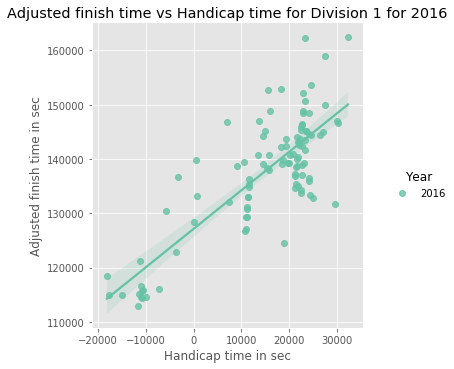

In [256]:
g = sns.lmplot("crctn_in_sec", "cln_crrct_tm_sec", merge_sail_winsor[(merge_sail_winsor['Division_only']\
    =='Division I -') & (merge_sail_winsor['Year']==2016)], hue="Year", palette="Set2")
g = (g.set_axis_labels("Handicap time in sec","Adjusted finish time in sec"))#.set(xlim=(0,10),ylim=(0,100)))
plt.title("Adjusted finish time vs Handicap time for Division 1 for 2016")
plt.show(g)

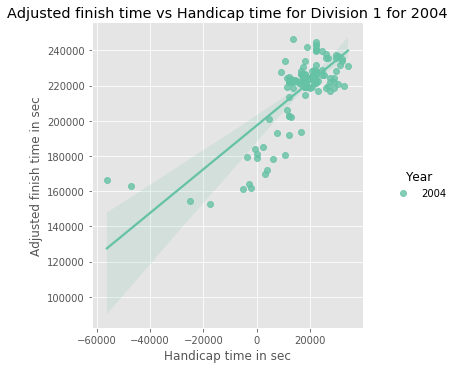

In [259]:
h = sns.lmplot("crctn_in_sec", "cln_crrct_tm_sec", merge_sail_winsor[(merge_sail_winsor['Division_only']\
    =='Division I -') & (merge_sail_winsor['Year']==2004)], hue="Year", palette="Set2")
h = (h.set_axis_labels("Handicap time in sec","Adjusted finish time in sec"))#.set(xlim=(0,10),ylim=(0,100)))
plt.title("Adjusted finish time vs Handicap time for Division 1 for 2004")
plt.show(h)

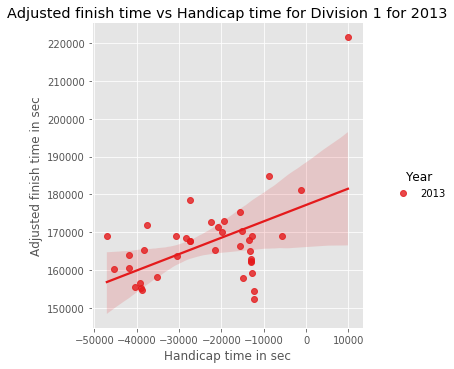

In [276]:
h = sns.lmplot("crctn_in_sec", "cln_crrct_tm_sec", merge_sail_winsor[(merge_sail_winsor['Division_only']\
    =='Division I -') & (merge_sail_winsor['Year']==2013)], hue="Year", palette="Set1")
h = (h.set_axis_labels("Handicap time in sec","Adjusted finish time in sec"))#.set(xlim=(0,10),ylim=(0,100)))
plt.title("Adjusted finish time vs Handicap time for Division 1 for 2013")
plt.show(h)

## Run linear regression model to confirm there is a relationship

Read in data and then turn into X and y for regression.  Iterate over period from 2002 to 2019 and determine correlation.

In [315]:
merge_sail_winsor.describe()

,Year,cln_elps_tm_sec,cln_crrct_tm_sec,crctn_in_sec
count,3699.000000,3699.000000,3694.000000,3694.000000
mean,2010.034063,165008.187618,158362.112344,6640.310233
std,5.228311,38101.452774,35124.014725,20612.216799
min,2002.000000,53840.000000,78785.000000,-116714.000000
25%,2005.000000,138040.500000,134720.500000,-5480.000000
50%,2010.000000,159728.000000,153662.500000,7378.000000
75%,2015.000000,185301.500000,178220.500000,21681.750000
max,2019.000000,342000.000000,295025.000000,71908.000000


In [329]:
yr_corr = []
trls_to_av = 15
for yr in range(2002,2019):
    rscoresum = 0
    for trl in range(trls_to_av):
        temp_df = merge_sail_winsor[(merge_sail_winsor['Division_only']=='Division I -')\
                                    & (merge_sail_winsor['Year']== yr)]
        temp_df_binary = temp_df[["crctn_in_sec", "cln_crrct_tm_sec"]]
        temp_df_binary.columns = ["crctn_in_sec", "cln_crrct_tm_sec"]
        X = np.array(temp_df_binary['crctn_in_sec']).reshape(-1, 1) 
        y = np.array(temp_df_binary['cln_crrct_tm_sec']).reshape(-1, 1) 

        # Dropping any rows with Nan values 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

        # Splitting the data into training and testing data 
        regr = LinearRegression() 

        regr.fit(X_train, y_train) 
        rscore = regr.score(X_test, y_test)
        rscoresum = rscore + rscoresum
    yr_corr = yr_corr + [(yr, rscoresum/trls_to_av)]
yr_corr

[(2002, 0.21284292097126958),
 (2003, 0.09680759293900627),
 (2004, 0.5418274265217449),
 (2005, 0.3764510020384781),
 (2006, 0.0726571494540263),
 (2007, 0.2933765806969453),
 (2008, 0.2513340065847175),
 (2009, -0.16861525184237144),
 (2010, 0.1516183070940013),
 (2011, 0.28322106190081),
 (2012, 0.27749432166800575),
 (2013, -0.266521372248749),
 (2014, -0.1881088063050021),
 (2015, 0.17974060991319424),
 (2016, 0.6122827410228108),
 (2017, 0.07875833376365776),
 (2018, -0.08715916561401953)]

Enter into linear regression package, calculate correlation coefficient.  Coefficient of 77% is clearly significant

In [345]:
merge_sail_winsor[merge_sail_winsor['Division_only']=='Division I -'].groupby('Year')['cln_crrct_tm_sec'].mean()

Year
2002    168423.357664
2003    157305.569536
2004    217400.440945
2005    147468.769841
2006    160366.085714
2007    220501.105960
2008    122216.992308
2009    178859.446429
2010    205785.962025
2011    196446.543478
2012    185948.242424
2013    167178.589744
2014    171081.382353
2015    167308.130769
2016    137491.605769
2017    117732.758929
2018    203325.684783
2019    144302.028302
Name: cln_crrct_tm_sec, dtype: float64

Text(0.5, 1.0, 'Detroit-Mackinac races: Division 1 2002-2019')

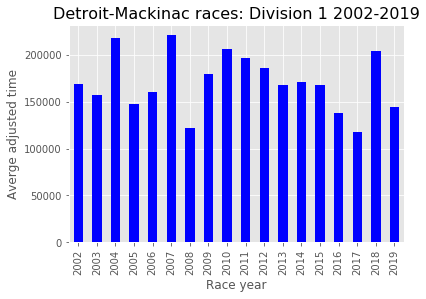

In [347]:
merge_sail_winsor[merge_sail_winsor['Division_only']=='Division I -'].groupby('Year')['cln_crrct_tm_sec'].mean().plot.bar(color='b')
plt.xlabel('Race year')
plt.ylabel('Averge adjusted time')
plt.title('Detroit-Mackinac races: Division 1 2002-2019', fontsize=16)

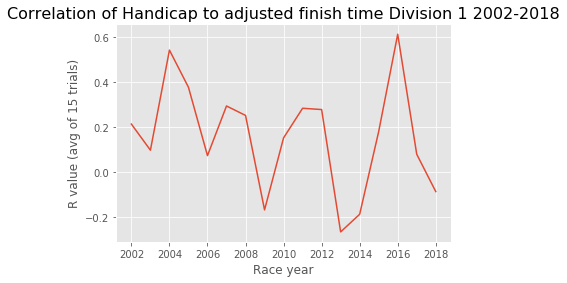

In [348]:
x_val = [x[0] for x in yr_corr]
y_val = [x[1] for x in yr_corr]

plt.plot(x_val,y_val)
# plt.plot(x_val,y_val,'or')
plt.xlabel('Race year')
plt.ylabel('R value (avg of 15 trials)')
plt.title('Correlation of Handicap to adjusted finish time Division 1 2002-2018', fontsize=16)
plt.show()

Number of entries per year, declining over time with variation

Text(0.5, 1.0, 'Detroit-Mackinac entrants 2002-2019')

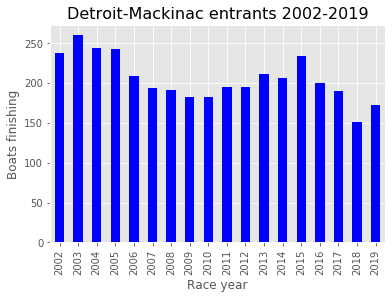

In [238]:
merge_sail_winsor.groupby('Year')['Elapsed_Time'].count().plot.bar(color='b')
plt.xlabel('Race year')
plt.ylabel('Boats finishing')
plt.title('Detroit-Mackinac entrants 2002-2019', fontsize=16)

Less good correlation but still likely significant in 2012

In [239]:
temp_df = merge_sail_winsor[(merge_sail_winsor['Division_only']=='Division I -') & (merge_sail_winsor['Year']==2012)]
temp_df_binary = temp_df[["crctn_in_sec", "cln_crrct_tm_sec"]]
temp_df_binary.columns = ["crctn_in_sec", "cln_crrct_tm_sec"]
X = np.array(temp_df_binary['crctn_in_sec']).reshape(-1, 1) 
y = np.array(temp_df_binary['cln_crrct_tm_sec']).reshape(-1, 1) 

In [240]:
# Dropping any rows with Nan values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
  
# Splitting the data into training and testing data 
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test)) 

0.3895718266345528


Bar plot of DNFs by year.  Only some years had any, but 2004 had a particularly large number.  Interestingly the wind was very light that year.

Text(0.5, 1.0, 'Detroit-Mackinac races 2002-2019')

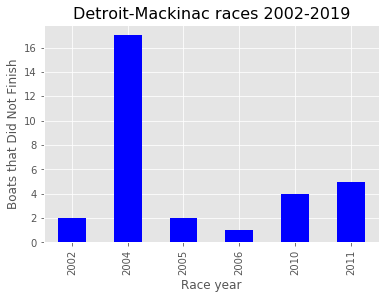

In [241]:
merge_sail[merge_sail['Elapsed_Time'] == 'DNF'].groupby('Year')['Elapsed_Time'].count().\
    plot.bar(color='b')
plt.xlabel('Race year')
plt.ylabel('Boats that Did Not Finish')
plt.title('Detroit-Mackinac races 2002-2019', fontsize=16)

In [232]:
type(merge_sail[merge_sail['Elapsed_Time'] == 'DNF'].groupby('Year')['Elapsed_Time'].count())

pandas.core.series.Series

Text(0.5, 1.0, 'Detroit-Mackinac races 2002-2019')

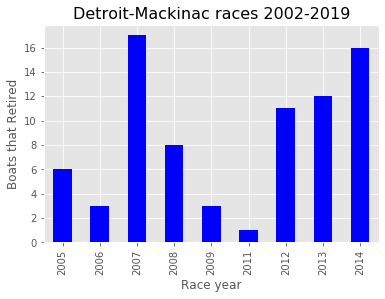

In [242]:
merge_sail[merge_sail['Elapsed_Time'] == 'Retired'].groupby('Year')['Elapsed_Time'].count().\
    plot.bar(color='b')
plt.xlabel('Race year')
plt.ylabel('Boats that Retired')
plt.title('Detroit-Mackinac races 2002-2019', fontsize=16)

In [233]:
dnf = merge_sail[merge_sail['Elapsed_Time'] == 'DNF'].groupby('Year')['Elapsed_Time'].count()
dns = merge_sail[merge_sail['Elapsed_Time'] == 'DNS'].groupby('Year')['Elapsed_Time'].count()
rtrd = merge_sail[merge_sail['Elapsed_Time'] == 'Retired'].groupby('Year')['Elapsed_Time'].count()
entrants = merge_sail_winsor.groupby('Year')['Elapsed_Time'].count()